# Perform submodular optimization to identify portfolio

## Import modules

In [2]:
import openml
import numpy as np
import json
import pandas as pd
import importlib
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from utils import functions_best_setups
from utils.functions_best_setups import sub_opt, perf_imp

importlib.reload(functions_best_setups)


# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

## Get HGB evaluation matrix

In [4]:
# get HGB evals
evals_hgb = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[12736],
                                            output_format='dataframe')

evals_hgb.shape

(35708, 14)

In [5]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_hgb.setup_id.value_counts()).index[(evals_hgb.setup_id.value_counts() >= 68)]
evals_subset_hgb = evals_hgb[evals_hgb.setup_id.isin(ids)]

# transform to wide format
evals_wide_hgb = evals_subset_hgb.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')


In [6]:
evals_wide_hgb = evals_wide_hgb.drop([3573, 146825, 167124], axis = 1)
evals_wide_hgb


task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8168895,0.840000,0.500021,0.500546,0.500000,0.500000,0.644844,0.500000,0.500000,0.500000,0.505050,...,0.520221,0.500000,0.499851,0.500000,0.500000,0.500006,0.514574,0.500218,0.500272,0.813266
8168910,0.999597,0.999704,0.980430,0.998846,0.983405,0.990940,0.998489,0.954767,0.971019,0.707143,...,0.939711,0.989274,1.000000,0.994930,0.998962,0.974505,0.521389,0.980906,0.994357,0.928592
8168921,0.999661,0.999729,0.967361,0.998572,0.983552,0.990841,0.998274,0.947665,0.955634,0.695659,...,0.942308,0.989258,0.999990,0.995286,0.998738,0.981950,0.517092,0.978584,0.994514,0.922842


## Get SVC evaluation matrix

### Get evaluations

In [5]:
# get SVC evals
evals_svc = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[16374, 16347, 16345, 16366], 
                                            output_format='dataframe')

evals_svc = evals_svc[evals_svc.upload_time>'2019-11-16 22:50:39']

In [6]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 146821, 167125, 167140, 3573]
evals_mixed_svc = evals_svc[evals_svc.task_id.isin(mixed_tasks)]
evals_mixed_svc.shape
len(evals_mixed_svc.setup_id.unique())

3307

In [7]:
# get evals of pure tasks
#ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 19)]
evals_pure_svc = evals_svc[~evals_svc.task_id.isin(mixed_tasks)]
evals_pure_svc.shape
len(evals_pure_svc.setup_id.unique())

539

### Get setups

In [8]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_svc.columns)
param_names = ['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape',
               'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state',
               'shrinking', 'tol', 'verbose']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_svc.iterrows():
    setup_model = openml.setups.initialize_model(i[1].setup_id)
    params = setup_model.steps[2][1].get_params().values()
    setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)

In [9]:
# get setups of pure tasks
setup_info_names = ['setup_id']
param_names = list(openml.setups.initialize_model(8231383).steps[2][1].get_params().keys())

setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_svc.setup_id.unique():
    setup_model = openml.setups.initialize_model(i)
    params = setup_model.steps[2][1].get_params().values()
    
    setups_pure.loc[len(setups_pure)] = [i]+list(params)


### Match and reassign setups to correct setup_ids

In [10]:
# match setup_ids
param_keys = ['C', 'coef0', 'degree', 'gamma', 'kernel', 'max_iter']
id_match = pd.DataFrame(columns= ['setup_id_mixed', 'setup_id'])

for i in range(len(setups_mixed)):
    print(i, end='\r')
    for j in range(len(setups_pure)):
        if all(setups_mixed.loc[i][param_keys] == setups_pure.loc[j][param_keys]): 
            id_match.loc[len(id_match)] = (setups_mixed.loc[i]['setup_id'], setups_pure.loc[j]['setup_id'])

In [13]:
# reassign setup_ids
evals_mixed_final = pd.DataFrame(columns = evals_mixed_svc.columns.values)

for i in id_match.iterrows():
    try:
        x = evals_mixed_svc[evals_mixed_svc.setup_id == i[1][0]]
        x.iat[0,2] = i[1][1]
        evals_mixed_final.loc[len(evals_mixed_final)] = list(x.values[0])
    except Exception as e:
        print(e, end ='')
    

### Recreate evaluation matrix with matched setups

In [332]:
# merge pure and mixed setups
evals_svc = evals_pure_svc.append(evals_mixed_final)

In [333]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 30)]
evals_subset_svc = evals_svc[evals_svc.setup_id.isin(ids)]

# transform to wide format
evals_wide_svc = evals_subset_svc.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [334]:
evals_wide_svc

task_id,3,6,11,12,14,15,16,18,22,23,...,125922,146800,146817,146819,146820,146822,146824,167119,167120,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8255509,0.979148,0.989495,0.981979,0.999275,0.980622,0.994573,0.998110,NaN,NaN,0.693388,...,0.999745,0.999696,0.902443,0.952077,0.991964,0.974699,0.999370,NaN,NaN,0.880809
8255510,0.986995,0.993091,0.980991,0.999125,0.982386,0.994972,0.997976,0.960343,NaN,0.682877,...,0.999954,0.999619,0.902759,0.949613,0.985389,0.980924,0.998829,NaN,NaN,0.883022
8255511,0.999868,NaN,0.999104,0.950226,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999987,NaN,0.919777,0.925189,0.993476,0.992367,0.524062,NaN,NaN,NaN
8255513,0.990997,0.995431,0.987158,0.999425,0.981152,0.994582,0.999211,0.958083,NaN,0.721782,...,0.999908,0.999986,0.915162,0.949503,0.992449,0.980378,0.999548,NaN,NaN,0.887175
8255514,0.989217,0.993589,0.981123,0.999137,0.981871,0.994981,0.997771,0.961297,NaN,0.682734,...,0.999966,0.999634,0.903286,0.952561,0.985148,0.981547,0.998824,NaN,NaN,0.882811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.920700,NaN,0.964759,0.997585,0.963252,NaN,0.993484,NaN,NaN,0.687027,...,0.985277,0.960719,0.881620,0.950713,0.765970,0.941302,0.997845,NaN,NaN,0.748707
8255938,0.990832,0.994135,0.980422,0.999124,0.981244,0.995053,0.997768,0.966006,0.986707,0.684563,...,0.999972,0.999585,0.904997,0.952781,0.978551,0.983655,0.998746,0.785172,NaN,0.581293
8255939,0.991260,0.997457,0.953448,0.493664,0.489772,0.977631,0.497107,0.963570,0.538000,0.577637,...,0.999185,0.367981,0.875179,0.430228,0.960503,0.988708,0.495350,0.898225,NaN,0.412310


# Get RF evaluation matrix

### Get evaluations

In [7]:
# get SVC evals
evals_rf = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[8351, 17651, 17652, 17653,17654, 17655], 
                                            output_format='dataframe')

evals_rf = evals_rf[evals_rf.upload_time>'2020-01-01 22:50:39']

In [8]:
evals_rf.groupby("task_id").task_id.count()

task_id
6         217
11        217
12        221
14        239
15        232
16        222
18        229
22        217
23        217
28        217
29        217
31        231
32        226
37        217
43        217
53        217
219       217
2074      217
2079      217
3022      217
3481       90
3549      217
3902      217
3903      217
3904      217
3913      217
3917      217
3918      230
7592      195
9910      217
9946      217
9952      384
9957      217
9960      217
9964      217
9971      217
9976      217
9977      221
9978      217
9981      227
9985      223
10093     217
10101     217
14954     226
14965     220
14969     217
14970     124
125920    350
125922    217
146800    217
146817    217
146819    241
146820    217
146822    217
146824    232
167119    217
167120    165
167141    217
Name: task_id, dtype: int64

In [9]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 146821, 167125, 167140, 3573]
evals_mixed_rf = evals_rf[evals_rf.task_id.isin(mixed_tasks)]
evals_mixed_rf.shape
len(evals_mixed_rf.setup_id.unique())

2958

In [10]:
# get evals of pure tasks
#ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 19)]
evals_pure_rf = evals_rf[~evals_rf.task_id.isin(mixed_tasks)]
evals_pure_rf.shape
len(evals_pure_rf.setup_id.unique())

466

### Get setups

In [30]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_rf.columns)
param_names = ['bootstrap', 'class_weight', 'criterion', 'max_depth', 
               'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 
               'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 
               'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 
               'oob_score', 'random_state', 'verbose', 'warm_start']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_rf.iterrows():
    try:
        setup_model = openml.setups.initialize_model(i[1].setup_id)
        params = setup_model.steps[2][1].get_params().values()
        setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)
    except Exception as e:
        print(e)

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

In [28]:
# get setups of pure tasks
setup_info_names = ['setup_id']
setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_rf.setup_id.unique():
    try:
        setup_model = openml.setups.initialize_model(i)
        params = setup_model.steps[2][1].get_params().values()
        setups_pure.loc[len(setups_pure)] = [i]+list(params)
    except Exception as e:
        print(e)


Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

### Match and reassign setups to correct setup_ids

In [32]:
# match setup_ids
param_keys = ['max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 
               'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 
               'min_weight_fraction_leaf', 'n_estimators',]
id_match = pd.DataFrame(columns= ['setup_id_mixed', 'setup_id'])

for i in range(len(setups_mixed)):
    print(i, end='\r')
    for j in range(len(setups_pure)):
        if all(setups_mixed.loc[i][param_keys] == setups_pure.loc[j][param_keys]): 
            id_match.loc[len(id_match)] = (setups_mixed.loc[i]['setup_id'], setups_pure.loc[j]['setup_id'])

In [34]:
# reassign setup_ids
evals_mixed_final = pd.DataFrame(columns = evals_mixed_rf.columns.values)

for i in id_match.iterrows():
    try:
        x = evals_mixed_rf[evals_mixed_rf.setup_id == i[1][0]]
        x.iat[0,2] = i[1][1]
        evals_mixed_final.loc[len(evals_mixed_final)] = list(x.values[0])
    except Exception as e:
        print(e, end ='')
    

### Recreate evaluation matrix with matched setups

In [35]:
# merge pure and mixed setups
evals_rf = evals_pure_rf.append(evals_mixed_final)

In [36]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_rf.setup_id.value_counts()).index[(evals_rf.setup_id.value_counts() >= 30)]
evals_subset_rf = evals_rf[evals_rf.setup_id.isin(ids)]

# transform to wide format
evals_wide_rf = evals_subset_rf.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [37]:
evals_wide_svc

NameError: name 'evals_wide_svc' is not defined

## Merge HGB and SVC data 

In [335]:
evals_wide_merged = pd.concat([evals_wide_hgb, evals_wide_svc])
evals_wide_merged

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.920700,NaN,0.964759,0.997585,0.963252,NaN,0.993484,NaN,NaN,0.687027,...,0.950713,0.765970,NaN,0.941302,0.997845,NaN,NaN,NaN,NaN,0.748707
8255938,0.990832,0.994135,0.980422,0.999124,0.981244,0.995053,0.997768,0.966006,0.986707,0.684563,...,0.952781,0.978551,NaN,0.983655,0.998746,0.785172,NaN,NaN,NaN,0.581293
8255939,0.991260,0.997457,0.953448,0.493664,0.489772,0.977631,0.497107,0.963570,0.538000,0.577637,...,0.430228,0.960503,NaN,0.988708,0.495350,0.898225,NaN,NaN,NaN,0.412310


## Clean merged data

In [336]:
evals_wide_merged[evals_wide_merged < 0.5] = np.nan

## Standardize merged data

In [337]:
evals_wide_merged.loc[len(evals_wide_merged)] = 0.5

evals_merged_std = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_wide_merged), 
                               index= evals_wide_merged.index,
                               columns = evals_wide_merged.columns)

evals_wide_merged = evals_wide_merged.drop(evals_wide_merged.index[-1], axis=0)
evals_merged_std = evals_merged_std.drop(evals_merged_std.index[-1], axis=0)
evals_merged_std = evals_merged_std.fillna(0)

In [383]:
evals_svc_std = evals_merged_std.loc[evals_wide_svc.index,:]
evals_hgb_std = evals_merged_std.loc[evals_wide_hgb.index,:]

## Rank merged data

In [384]:
evals_wide_merged = evals_wide_merged.fillna(0.5)
evals_merged_rank = evals_wide_merged.rank(method='first')

evals_svc_rank = evals_merged_rank.loc[evals_wide_svc.index,:]
evals_hgb_rank = evals_merged_rank.loc[evals_wide_hgb.index,:]

## Submodular optimization AUC (min-max scaled, mean)

In [279]:
def eval_transformer(evals, replace_missing=True, order_id=False):
    # normalize evaluation metrics within tasks
    
    evals_norm = evals.copy(deep=True)
    evals_norm.loc[len(evals_norm)] = 0
    
    evals_norm = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_norm), 
                               index= evals_norm.index,
                               columns = evals_norm.columns)
    
    evals_norm = evals_norm.drop(evals_norm.index[-1], axis=0)
    
    if replace_missing==True:
        evals_norm = evals_norm.fillna(0)
        
        
    if order_id==True:
        order_setups = np.argsort(evals_norm.index)
        order_tasks = np.argsort(evals_norm.columns)
        
    else:                 
        order_setups = np.argsort(evals_norm.mean(axis = 1))
        order_tasks = np.argsort(evals_norm.mean(axis = 0))
        
    evals_norm_ordered = evals_norm.iloc[order_setups, order_tasks]
    
    return evals_norm_ordered

In [ ]:
def eval_transformer(evals, replace_missing=True, order_id=False):
    # normalize evaluation metrics within tasks
    
    evals_norm = evals.copy(deep=True)
    evals_norm.loc[len(evals_norm)] = 0
    
    evals_norm = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_norm), 
                               index= evals_norm.index,
                               columns = evals_norm.columns)
    
    evals_norm = evals_norm.drop(evals_norm.index[-1], axis=0)
    
    if replace_missing==True:
        evals_norm = evals_norm.fillna(0)
        
        
    if order_id==True:
        order_setups = np.argsort(evals_norm.index)
        order_tasks = np.argsort(evals_norm.columns)
        
    else:                 
        order_setups = np.argsort(evals_norm.mean(axis = 1))
        order_tasks = np.argsort(evals_norm.mean(axis = 0))
        
    evals_norm_ordered = evals_norm.iloc[order_setups, order_tasks]
    
    return evals_norm_ordered

In [280]:
evals_wide_merged_norm_ordered = eval_transformer(evals_wide_merged, replace_missing=False)
evals_wide_merged_norm_clean_ordered = eval_transformer(evals_wide_merged, replace_missing=True)

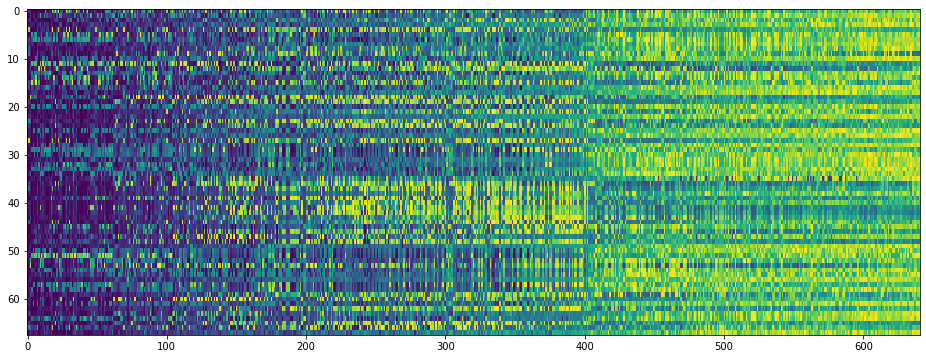

In [368]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_merged_rank.T, aspect = 'auto')

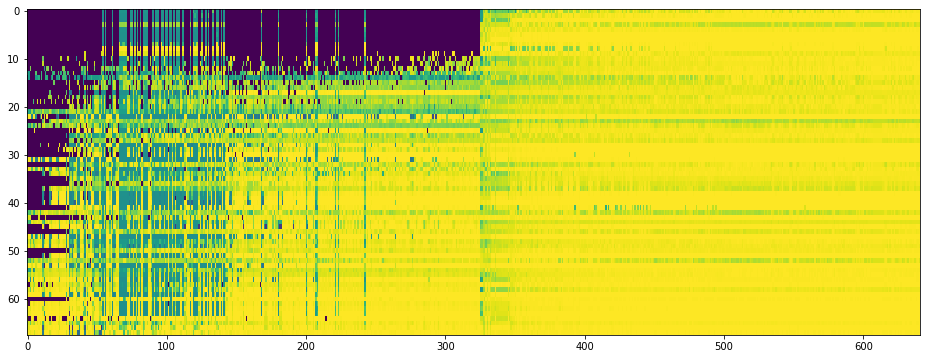

In [284]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_merged_norm_clean_ordered.T, aspect = 'auto')

## Plot performance improvement for each additional classifier

In [374]:
setup_id, portfolio_performance = perf_imp(evals_merged_rank, evals_merged_rank, criterion='mean', verbose = True)


sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.en

# Compare performance

## Standardized mean

In [413]:
setup_id, pp_merged_mean_std, pp_merged_sem_std = perf_imp(evals_merged_std, evals_merged_std, 'mean')
setup_id, pp_hgb_mean_std, pp_hgb_sem_std = perf_imp(evals_hgb_std, evals_hgb_std, 'mean')
setup_id, pp_svc_mean_std, pp_svc_sem_std = perf_imp(evals_svc_std, evals_svc_std, 'mean')

In [414]:
merged_std_u = [i + j for i, j in zip(pp_merged_mean_std[0:50], pp_merged_sem_std[0:50])]
merged_std_l = [i - j for i, j in zip(pp_merged_mean_std[0:50], pp_merged_sem_std[0:50])]
hgb_std_u = [i + j for i, j in zip(pp_hgb_mean_std[0:50], pp_hgb_sem_std[0:50])]
hgb_std_l = [i - j for i, j in zip(pp_hgb_mean_std[0:50], pp_hgb_sem_std[0:50])]
svc_std_u = [i + j for i, j in zip(pp_svc_mean_std[0:50], pp_svc_sem_std[0:50])]
svc_std_l = [i - j for i, j in zip(pp_svc_mean_std[0:50], pp_svc_sem_std[0:50])]

''

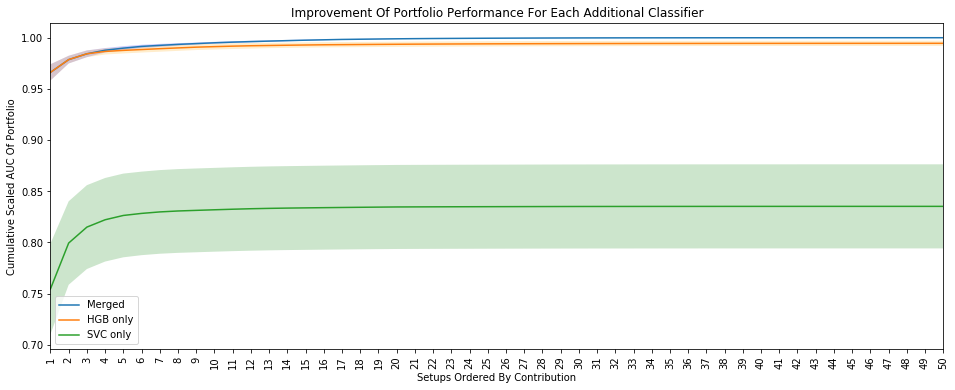

In [432]:
ax1 = pd.Series(pp_merged_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))

ax1.fill_between(range(0,50), merged_std_u, merged_std_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_std_u, hgb_std_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_std_u, svc_std_l, alpha=0.2, facecolor='green')

ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Cumulative Scaled AUC Of Portfolio')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

''

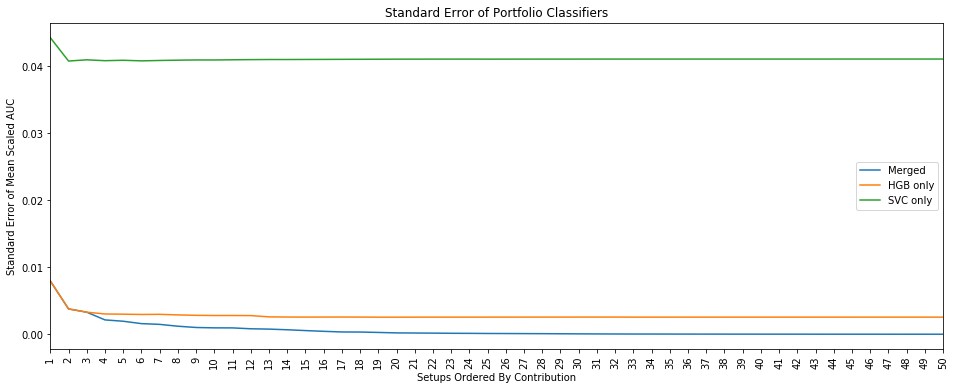

In [435]:
ax1 = pd.Series(pp_merged_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))

ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'Merged max'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Scaled AUC)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;

## Ranked mean

In [574]:
setup_id, pp_merged_mean_rank, pp_merged_sem_rank = perf_imp(evals_merged_rank, evals_merged_std, 'mean')
setup_id, pp_hgb_mean_rank, pp_hgb_sem_rank = perf_imp(evals_hgb_rank, evals_hgb_std, 'mean')
setup_id, pp_svc_mean_rank, pp_svc_sem_rank = perf_imp(evals_svc_rank, evals_svc_std, 'mean')

In [575]:
merged_rank_u = [i + j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
merged_rank_l = [i - j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
hgb_rank_u = [i + j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
hgb_rank_l = [i - j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
svc_rank_u = [i + j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
svc_rank_l = [i - j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]

''

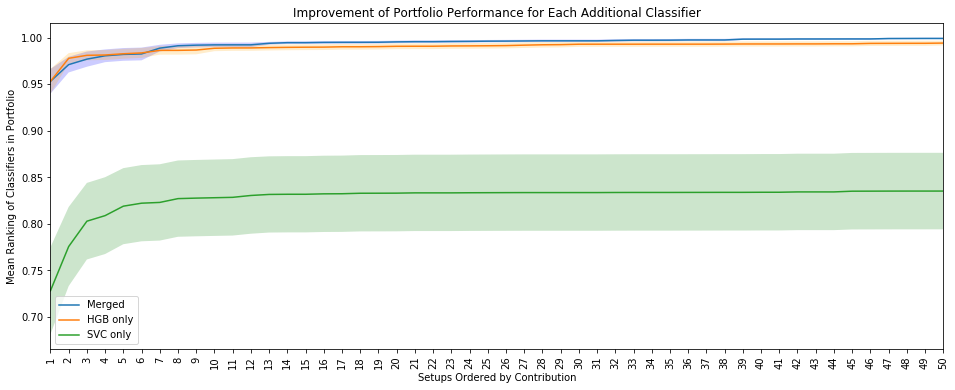

In [576]:
ax1 = pd.Series(pp_merged_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))

ax1.fill_between(range(0,50), merged_rank_u, merged_rank_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_rank_u, hgb_rank_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_rank_u, svc_rank_l, alpha=0.2, facecolor='green')

ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Mean Ranking of Classifiers in Portfolio')
ax1.set_xlabel('Setups Ordered by Contribution')
ax1.set_title('Improvement of Portfolio Performance for Each Additional Classifier')
;

''

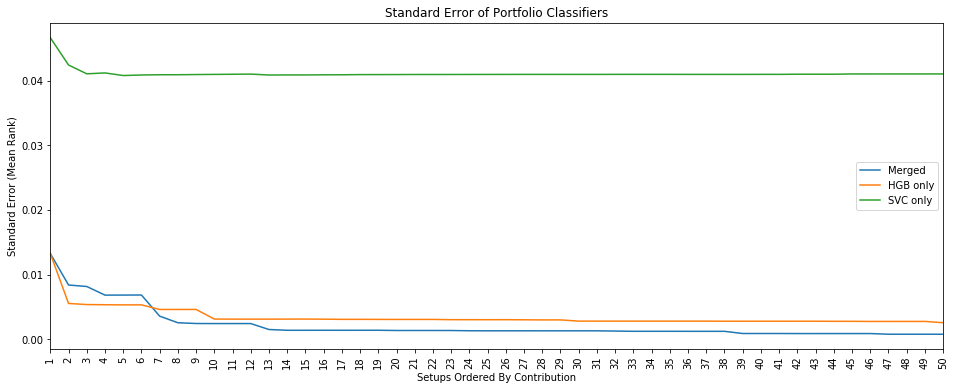

In [577]:
ax1 = pd.Series(pp_merged_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))

ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'Merged max'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Rank)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;


# Get model condigurations

## Merged portfolio by rank

In [419]:
# get ensemble of X setups
setup_list_merged_rank = sub_opt(evals_merged_rank, 31, 'mean')
print(setup_list_merged_rank)

[8166999, 8255634, 8157910, 8255687, 8155841, 8255823, 8158225, 8255623, 8156377, 8256151, 8154931, 8255719, 8155253, 8154596, 8155760, 8158033, 8255531, 8155577, 8255694, 8255723, 8154535, 8168910, 8155405, 8154591, 8157501, 8154742, 8154465, 8157985, 8255695, 8158182, 8155425, 8157367]


In [422]:
openml.setups.initialize_model(8166999)[-1]

HistGradientBoostingClassifier(l2_regularization=1e-06, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=None,
                               max_iter=200, max_leaf_nodes=128,
                               min_samples_leaf=50, n_iter_no_change=None,
                               random_state=23617, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0)

In [569]:
counter = 1
for i in setup_list_merged_rank:
    
    clf = openml.setups.initialize_model(i)[-1]
    
    if 'Hist' in str(type(clf)):
        print('HistGradientBoostingClassifier(l2_regularization='+str(clf.get_params()['l2_regularization'])+',\n',
             'learning_rate='+str(clf.get_params()['learning_rate'])+',',
             "loss='"+str(clf.get_params()['loss'])+"',\n",
             'max_bins='+str(clf.get_params()['max_bins'])+',',
             'max_depth='+str(clf.get_params()['max_depth'])+',\n',
             'max_iter='+str(clf.get_params()['max_iter'])+',',
             'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',\n',
             'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+'),')
        
    elif 'SVC' in str(type(clf)):
        print('SVC(C='+str(clf.get_params()['C'])+',',
              'coef0='+str(clf.get_params()['coef0'])+',',
              'degree='+str(clf.get_params()['degree'])+',\n',
              'gamma='+str(clf.get_params()['gamma'])+',',
              "kernel='"+str(clf.get_params()['kernel'])+"',",
              'probability=False),')
    print()
    counter += 1

HistGradientBoostingClassifier(l2_regularization=1e-06,
 learning_rate=0.1, loss='auto',
 max_bins=256, max_depth=None,
 max_iter=200, max_leaf_nodes=128,
 min_samples_leaf=50),

SVC(C=52.368035023140784, coef0=0.0, degree=3,
 gamma=0.008051730038808798, kernel='rbf', probability=False),

HistGradientBoostingClassifier(l2_regularization=10.0,
 learning_rate=0.1, loss='auto',
 max_bins=256, max_depth=15,
 max_iter=200, max_leaf_nodes=64,
 min_samples_leaf=1),

SVC(C=1.799125831143992, coef0=0.7926565732345652, degree=3,
 gamma=0.01858955180141993, kernel='poly', probability=False),

HistGradientBoostingClassifier(l2_regularization=0.001,
 learning_rate=0.1, loss='auto',
 max_bins=256, max_depth=18,
 max_iter=450, max_leaf_nodes=64,
 min_samples_leaf=9),

SVC(C=2854.2115055717222, coef0=0.9097801350305286, degree=2,
 gamma=0.0594124208513135, kernel='rbf', probability=False),

HistGradientBoostingClassifier(l2_regularization=100.0,
 learning_rate=0.1, loss='auto',
 max_bins=256, max_dept

In [561]:
'Hist' in str(type(clf))

True

## HGB portfolio by rank

In [438]:
setup_list_hgb_rank = sub_opt(evals_hgb_rank, 31, 'mean')
print(setup_list_hgb_rank)

[8166999, 8158101, 8154931, 8158087, 8156960, 8156260, 8155322, 8155006, 8168841, 8154370, 8155577, 8156853, 8157985, 8155841, 8154742, 8156228, 8157397, 8156931, 8154704, 8155405, 8157910, 8157828, 8154591, 8155247, 8155061, 8154535, 8157367, 8167220, 8155196, 8156475, 8168865, 8168910]


In [553]:
counter = 1
for i in setup_list_hgb_rank:

    clf = openml.setups.initialize_model(i)[-1]
    print('HistGradientBoostingClassifier(l2_regularization='+str(clf.get_params()['l2_regularization'])+',\n',
         'learning_rate='+str(clf.get_params()['learning_rate'])+',',
         "loss='"+str(clf.get_params()['loss'])+"',",
         'max_bins='+str(clf.get_params()['max_bins'])+',',
         'max_depth='+str(clf.get_params()['max_depth'])+',\n',
         'max_iter='+str(clf.get_params()['max_iter'])+',',
         'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',',
         'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+'),')
    counter += 1

HistGradientBoostingClassifier(l2_regularization=1e-06,
 learning_rate=0.1, loss='auto', max_bins=256, max_depth=None,
 max_iter=200, max_leaf_nodes=128, min_samples_leaf=50),
HistGradientBoostingClassifier(l2_regularization=1.0,
 learning_rate=0.1, loss='auto', max_bins=64, max_depth=5,
 max_iter=100, max_leaf_nodes=4, min_samples_leaf=1),
HistGradientBoostingClassifier(l2_regularization=1.0,
 learning_rate=0.1, loss='auto', max_bins=64, max_depth=18,
 max_iter=350, max_leaf_nodes=32, min_samples_leaf=7),
HistGradientBoostingClassifier(l2_regularization=1e-07,
 learning_rate=0.1, loss='auto', max_bins=16, max_depth=19,
 max_iter=500, max_leaf_nodes=8, min_samples_leaf=27),
HistGradientBoostingClassifier(l2_regularization=10.0,
 learning_rate=0.1, loss='auto', max_bins=256, max_depth=16,
 max_iter=100, max_leaf_nodes=128, min_samples_leaf=8),
HistGradientBoostingClassifier(l2_regularization=1e-07,
 learning_rate=0.1, loss='auto', max_bins=256, max_depth=16,
 max_iter=350, max_leaf_node

In [542]:
clf = openml.setups.initialize_model(i)[-1]
print('HGB(l2_regularization='+str(clf.get_params()['l2_regularization'])+',',
     'learning_rate='+str(clf.get_params()['learning_rate'])+',',
     "loss='"+str(clf.get_params()['loss'])+"',",
     'max_bins='+str(clf.get_params()['max_bins'])+',',
     'max_depth='+str(clf.get_params()['max_depth'])+',',
     'max_iter='+str(clf.get_params()['max_iter'])+',',
     'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',',
     'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+',')

HGB(l2_regularization=1e-10, learning_rate=0.1, loss='auto', max_bins=128, max_depth=None, max_iter=500, max_leaf_nodes=8, min_samples_leaf=21,


## SVC portfolio by rank

In [441]:
setup_list_svc_rank = sub_opt(evals_svc_rank, 31, 'mean')
print(setup_list_svc_rank)

[8255833, 8255556, 8255630, 8255861, 8255939, 8255559, 8255569, 8255616, 8255619, 8255598, 8255623, 8255660, 8255687, 8255596, 8255617, 8255732, 8255532, 8255878, 8255853, 8255661, 8255778, 8255640, 8256151, 8255612, 8255808, 8255610, 8255639, 8255951, 8255714, 8255743, 8255862, 8255723]


In [546]:
counter = 1
for i in setup_list_svc_rank:
    
    clf = openml.setups.initialize_model(i)[-1]

    print('SVC(C='+str(clf.get_params()['C'])+',',
         'coef0='+str(clf.get_params()['coef0'])+',',
         'degree='+str(clf.get_params()['degree'])+',\n',
         'gamma='+str(clf.get_params()['gamma'])+',',
         "kernel='"+str(clf.get_params()['kernel'])+"',",
         'probability=False),')
    counter += 1

SVC(C=131.79955149814975, coef0=0.0, degree=3,
 gamma=0.005449601498518041, kernel='rbf', probability=False),
SVC(C=6.5031187555491305, coef0=0.3569381453006406, degree=4,
 gamma=0.15364377981481867, kernel='rbf', probability=False),
SVC(C=2.5918689981661567, coef0=0.3186996400686849, degree=3,
 gamma=0.0016271844595562733, kernel='rbf', probability=False),
SVC(C=8.537098039116069, coef0=0.0, degree=3,
 gamma=0.014430579841442782, kernel='rbf', probability=False),
SVC(C=33.252648089739836, coef0=0.0, degree=3,
 gamma=2.1212339071044592, kernel='rbf', probability=False),
SVC(C=55762.3529353618, coef0=-0.8056114085510306, degree=3,
 gamma=3.187772482265977e-05, kernel='sigmoid', probability=False),
SVC(C=149.07622270551335, coef0=0.0, degree=3,
 gamma=0.05610768111553853, kernel='rbf', probability=False),
SVC(C=0.38559962233936546, coef0=0.08722972305625087, degree=3,
 gamma=7.521110541330819, kernel='rbf', probability=False),
SVC(C=34.18479740302528, coef0=0.465809282171058, degree=3,
 

In [513]:
clf = openml.setups.initialize_model(i)[-1]
print('SVC(C='+str(clf.get_params()['C'])+',',
     'coef0='+str(clf.get_params()['coef0'])+',',
     'degree='+str(clf.get_params()['degree'])+',',
     'gamma='+str(clf.get_params()['gamma'])+',',
     "kernel='"+str(clf.get_params()['kernel'])+"',",
     'probability=False),')

sklearn.svm.classes.SVC

# Compare portfolios

In [597]:
task_perf_merged = evals_wide_merged.loc[setup_list_merged_rank,:].max()
task_perf_hgb = evals_wide_merged.loc[setup_list_hgb_rank,:].max()
task_perf_svc = evals_wide_merged.loc[setup_list_svc_rank,:].max()

task_perf_comp = pd.concat([task_perf_merged, task_perf_hgb, task_perf_svc], axis=1)

In [602]:
task_perf_comp = task_perf_comp.rename(columns={0: 'merged', 1: 'hgb', 2: 'svc'})

In [608]:
task_perf_comp

,merged,hgb,svc
task_id,,,
3,0.999912,0.999915,0.999905
6,0.999780,0.999780,0.999761
11,1.000000,0.996237,1.000000
12,0.999448,0.999216,0.999448
14,0.985049,0.985228,0.984730
...,...,...,...
167119,0.982298,0.982298,0.970455
167120,0.530643,0.529776,0.529891
167125,0.984479,0.984479,0.500000


In [614]:
task_perf_comp_rank = task_perf_comp.rank(axis=1, method='min', ascending=False)

In [622]:
rank_mean = task_perf_comp_rank.mean()
rank_sem = task_perf_comp_rank.sem()

Text(0, 0.5, 'Mean rank')

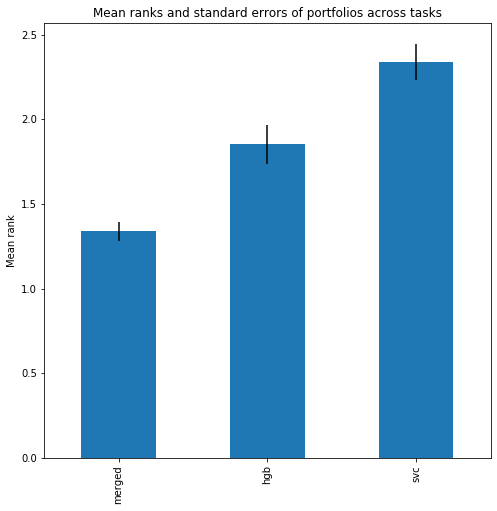

In [637]:
ax = rank_mean.plot(kind='bar', yerr=rank_sem, figsize=(8,8))
ax.set_title('Mean ranks and standard errors of portfolios across tasks')
ax.set_ylabel('Mean rank')

In [618]:
task_perf_comp_rank.sem()

merged    0.057799
hgb       0.113343
svc       0.108081
dtype: float64

In [626]:
x, y, yerr = rand(3, 10)
errorbar(x, y, yerr, marker='s', mfc='red',
         mec='green', ms=20, mew=4)

NameError: name 'rand' is not defined